# 基础因子实时计算

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
sys.path.append('../../../../')

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt

from PyFin.api import *
from alphamind.api import *
from conf.models import *
from conf.config import*
from data.engines.model import Record
from alphamind.execution.naiveexecutor import NaiveExecutor
from stacking import factor_store, feature_list
from optimization.bayes_optimization_xgb import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 100)


## 因子数据准备

In [2]:
# 设置train和predict日期
start_date = '2019-10-23'  # trainning起始时间
end_date = '2020-01-08'    # predict时间, 调仓日

# 设置交易日
trade_end_date = '2020-01-09'        # 当前交易日期[predict的下一个交易日作为下单调仓日]

# 设置保存的文件目录
weekly = 'st'  # 测试文件目录
freq = '5b'

# 换手率控制
turn_over_rate = 1.4  # {s1:0.5, s2:0.3, s3:0.6, s4:0.8, s5:0.5}

# 组合优化参数
weight_gap = 0.02

In [3]:
universe = Universe('zz500')
benchmark_code = 905
ref_dates = makeSchedule(start_date, end_date, freq, 'china.sse')
horizon = map_freq(freq)
industry_name = 'sw'
industry_level = 1

# 根据索引删除某些特殊日期{节假日, 零时停盘日等}
trash_date_list = [datetime(2020, 1, 1, 0, 0)]
a = []
for i in trash_date_list:
    try:
        del(ref_dates[ref_dates.index(i)])
    except:
        continue

# 前一个调仓日
ref_date_pre = ref_dates[-2]

# 当前调仓日
ref_date = ref_dates[-1]
print('前一个调仓日: %s' % ref_date_pre)
print('当前调仓日: %s' % ref_date)

# 获取前一个交易日, 用于获取前一个调仓日的持仓信息
date_range = makeSchedule(ref_date_pre, trade_end_date, '1d', 'china.sse')
# 前一个交易日, 如果遇到上一个调仓日存在空缺如[2020.01.01], 需要特殊指定
# adjusted_date_pre = datetime(2019, 12, 26, 0, 0)
adjusted_date_pre = date_range[1]

adjusted_date = date_range[-1]

# 因子数据库
data_source = alpha_db
engine = SqlEngine(data_source)

print('前一个交易日: %s' % adjusted_date_pre)
print('当前交易日: %s' % adjusted_date)

前一个调仓日: 2019-12-25 00:00:00
当前调仓日: 2020-01-08 00:00:00
前一个交易日: 2019-12-26 00:00:00
当前交易日: 2020-01-09 00:00:00


In [4]:
ref_dates, date_range

([datetime.datetime(2019, 10, 23, 0, 0),
  datetime.datetime(2019, 10, 30, 0, 0),
  datetime.datetime(2019, 11, 6, 0, 0),
  datetime.datetime(2019, 11, 13, 0, 0),
  datetime.datetime(2019, 11, 20, 0, 0),
  datetime.datetime(2019, 11, 27, 0, 0),
  datetime.datetime(2019, 12, 4, 0, 0),
  datetime.datetime(2019, 12, 11, 0, 0),
  datetime.datetime(2019, 12, 18, 0, 0),
  datetime.datetime(2019, 12, 25, 0, 0),
  datetime.datetime(2020, 1, 8, 0, 0)],
 [datetime.datetime(2019, 12, 25, 0, 0),
  datetime.datetime(2019, 12, 26, 0, 0),
  datetime.datetime(2019, 12, 27, 0, 0),
  datetime.datetime(2019, 12, 30, 0, 0),
  datetime.datetime(2019, 12, 31, 0, 0),
  datetime.datetime(2020, 1, 1, 0, 0),
  datetime.datetime(2020, 1, 2, 0, 0),
  datetime.datetime(2020, 1, 3, 0, 0),
  datetime.datetime(2020, 1, 6, 0, 0),
  datetime.datetime(2020, 1, 7, 0, 0),
  datetime.datetime(2020, 1, 8, 0, 0),
  datetime.datetime(2020, 1, 9, 0, 0)])

In [5]:
# uqer因子列表
## CSQuantiles
basic_factor_store = factor_store.basic_factor_store
## LAST
# basic_factor_store = factor_store.basic_factor_last_store

# alpha191因子列表
alpha_factor_store = factor_store.alpha_factor_store

In [6]:
%%time
# 提取Uqer因子
basic_factor_org = engine.fetch_factor_range(universe, basic_factor_store, dates=ref_dates)
## 提取alpha191因子
# alpha191_factor_org = engine.fetch_factor_range(universe, 
#                                                 alpha_factor_store, 
#                                                 dates=ref_dates, 
#                                                 used_factor_tables=[Alpha191]).drop(['chgPct','secShortName'],
#                                                                                     axis=1)
## 合并所有的因子
# factor_data_org = pd.merge(basic_factor_org, alpha191_factor_org, on=['trade_date', 'code'], how='outer')
factor_data_org = basic_factor_org


CPU times: user 11.9 s, sys: 435 ms, total: 12.3 s
Wall time: 13.7 s


In [9]:
assert len(set(factor_data_org['trade_date'])) == len(ref_dates)


Text(0, 0.5, 'ACCA')

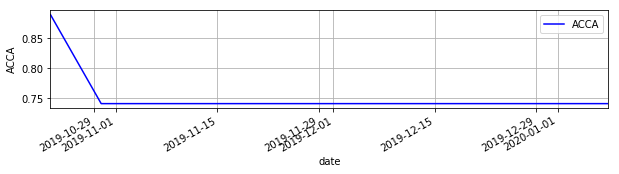

In [10]:
# Plot factor value over time on code
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 2 # width 10, height 8

ax = factor_data_org[factor_data_org['code'] == 6].plot(x='trade_date', y='ACCA', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("ACCA")

In [11]:
# 因子预处理
## 确失值填充
factor_mean = factor_data_org.mean()
factor_std = factor_data_org.std()
factor_data_org = factor_data_org.fillna(factor_mean)

In [12]:
%%time
# 获取所属行业
industry = engine.fetch_industry_range(universe, dates=ref_dates)
# factor_data = pd.merge(factor_data_org, industry, on=['trade_date', 'code']).fillna(0.)
factor_data = pd.merge(factor_data_org, industry, on=['trade_date', 'code'])

# 获取风险因子
risk_total = engine.fetch_risk_model_range(universe, dates=ref_dates)[1]


CPU times: user 149 ms, sys: 8.04 ms, total: 157 ms
Wall time: 287 ms


In [13]:
%%time
return_data = engine.fetch_dx_return_range(universe, dates=ref_dates, horizon=horizon, offset=0,benchmark = benchmark_code)
# return_data = engine.fetch_dx_return_range(universe, dates=ref_dates, horizon=horizon, offset=0)



CPU times: user 62.7 ms, sys: 0 ns, total: 62.7 ms
Wall time: 317 ms


In [14]:
%%time
benchmark_total = engine.fetch_benchmark_range(dates=ref_dates, benchmark=benchmark_code)
industry_total = engine.fetch_industry_matrix_range(universe, dates=ref_dates, category=industry_name, level=industry_level)

train_data = pd.merge(factor_data, return_data, on=['trade_date', 'code']).dropna()


CPU times: user 93.3 ms, sys: 2.46 ms, total: 95.8 ms
Wall time: 140 ms


Text(0, 0.5, 'dx')

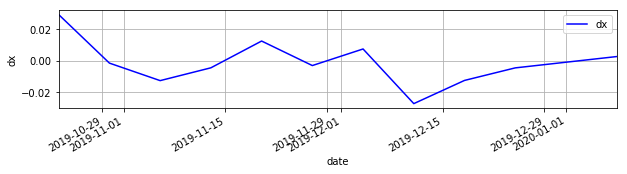

In [15]:
# Plot adjusted close over time on code
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 2 # width 10, height 8

ax = train_data[train_data['code'] == 6].plot(x='trade_date', y='dx', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("dx")

In [16]:
# 获取特征名
features = list(basic_factor_store.keys())
alpha_features = list(alpha_factor_store.keys())
# features = feature_list.uqer_features
# alpha_features = feature_list.alpha_features
# features.extend(alpha_features)

label = ['dx']

# 模型训练

In [17]:
from datetime import datetime, timedelta
from models.m1_xgb import *
from conf.configuration import xgb_conf
from data.engines.model import Record
import xgboost as xgb
import gc

alpha_logger.info('{0} is start'.format(ref_date))

# machine learning model
## Filter Training data
## 训练集构造
trade_date_pre = ref_date - timedelta(days=1)
# trade_date_pre_80 = ref_date - timedelta(days=80)

## 1、选择调仓日当天之前(不含当天)并且在80天以内的因子数据作为训练集.
# train = train_data[(train_data.trade_date <= trade_date_pre) & (trade_date_pre_80 <= train_data.trade_date)].dropna()
## 2、选择调仓日当天之前(不含当天)的因子数据作为训练集.
train = train_data[train_data.trade_date <= trade_date_pre].dropna()
alpha_logger.info('trade_date_pre {0}'.format(trade_date_pre))

if len(train) <= 0:
    alpha_logger.info('{0} HAS NO TRAIN DATA!!!'.format(ref_date))

x_train = train[features]
y_train = train[label]
alpha_logger.info('len_x_train: {0}, len_y_train: {1}'.format(len(x_train.values), len(y_train.values)))
alpha_logger.info('X_train.shape={0}, X_test.shape = {1}'.format(np.shape(x_train), np.shape(y_train)))


2020-01-13 09:33:21,492 - ALPHA_MIND - INFO - 2020-01-08 00:00:00 is start
2020-01-13 09:33:21,527 - ALPHA_MIND - INFO - trade_date_pre 2020-01-07 00:00:00
2020-01-13 09:33:21,534 - ALPHA_MIND - INFO - len_x_train: 5000, len_y_train: 5000
2020-01-13 09:33:21,534 - ALPHA_MIND - INFO - X_train.shape=(5000, 423), X_test.shape = (5000, 1)


## 超参寻优

In [18]:
%%time
# load xgboost regression configuration
xgb_conf.xgb_config_r()
xgb_conf.cv_folds = None
xgb_conf.early_stop_round = 100
xgb_conf.max_round = 800
xgb_conf.params.update({'nthread': 12})

GPU_device = False
if GPU_device:
    # use GPUs
    xgb_conf.params.update({'tree_method': 'gpu_hist'})
alpha_logger.info("params before: \n{}".format(xgb_conf.params))
tic = time.time()

# hyper_parameters optimization
# opt_parameters = {'max_depth': (2, 12),
#                   'gamma': (0.001, 10.0),
#                   'min_child_weight': (0, 20),
#                   'max_delta_step': (0, 10),
#                   'subsample': (0.01, 0.99),
#                   'colsample_bytree': (0.01, 0.99)
#                  }

# opt_xgb = BayesOptimizationXGB('regression', x_train, y_train)
# params_op = opt_xgb.train_opt(opt_parameters)
# xgb_conf.params.update(params_op)
alpha_logger.info("params after: \n{}".format(xgb_conf.params))
alpha_logger.info("hyper params optimize time : {}".format(time.time() - tic))


2020-01-13 09:33:21,540 - ALPHA_MIND - INFO - params before: 
{'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 12, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2020-01-13 09:33:21,541 - ALPHA_MIND - INFO - params after: 
{'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 12, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2020-01-13 09:33:21,541 - ALPHA_MIND - INFO - hyper params optimize time : 0.00044536590576171875


CPU times: user 1.89 ms, sys: 950 µs, total: 2.84 ms
Wall time: 1.93 ms


## 训练

In [19]:
%%time
# model training
xgb_model = XGBooster(xgb_conf)
alpha_logger.info('xgb_model params: \n{0}'.format(xgb_model.get_params()))

best_score, best_round, best_model = xgb_model.fit(x_train, y_train)
alpha_logger.info('Training time cost {}s'.format(time.time() - tic))
alpha_logger.info('best_score = {}, best_round = {}'.format(best_score, best_round))


2020-01-13 09:33:21,547 - ALPHA_MIND - INFO - xgb_model params: 
{'booster': 'gbtree', 'objective': 'reg:linear', 'eval_metric': ['rmse', 'logloss'], 'nthread': 12, 'silent': 1, 'learning_rate': 0.01, 'max_depth': 5, 'eta': 0.03, 'alpha': 0, 'lambda': 0, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'seed': 2019}
2020-01-13 09:33:21,547 - ../../../../models/m1_xgb.py[line:95] - INFO: NonCrossValidation。。。。


[0]	train-rmse:0.498084	train-logloss:0.683134
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 100 rounds.
[5]	train-rmse:0.473818	train-logloss:0.635901
[10]	train-rmse:0.450742	train-logloss:0.592935
[15]	train-rmse:0.428794	train-logloss:0.553688
[20]	train-rmse:0.407955	train-logloss:0.517772
[25]	train-rmse:0.388131	train-logloss:0.484734
[30]	train-rmse:0.369295	train-logloss:0.454299
[35]	train-rmse:0.351386	train-logloss:0.42617
[40]	train-rmse:0.334349	train-logloss:0.4001
[45]	train-rmse:0.318182	train-logloss:0.375949
[50]	train-rmse:0.302824	train-logloss:0.353509
[55]	train-rmse:0.288199	train-logloss:0.332572
[60]	train-rmse:0.274307	train-logloss:0.313057
[65]	train-rmse:0.261114	train-logloss:0.294842
[70]	train-rmse:0.248589	train-logloss:0.277824
[75]	train-rmse:0.236671	train-logloss:0.261869
[80]	train-rmse:0.225348	train-logloss:0.246914
[85]	train-rmse:0.214596	train-loglos

2020-01-13 09:33:25,799 - ALPHA_MIND - INFO - Training time cost 4.25826621055603s
2020-01-13 09:33:25,800 - ALPHA_MIND - INFO - best_score = {'best_score': -0.387507}, best_round = 799


CPU times: user 50.6 s, sys: 65 ms, total: 50.6 s
Wall time: 4.25 s


# 当天数据预测

In [20]:
# 取调仓日当天的因子数据作为输入.
# total_data_test_excess = train_data[train_data.trade_date == str(ref_date)]
total_data_test_excess = factor_data[factor_data.trade_date == ref_date]

if len(total_data_test_excess) <=0:
    alpha_logger.info('{} HAS NO DATA!!!'.format(ref_date))
    sys.exit()

alpha_logger.info('{0} total_data_test_excess: {1}'.format(ref_date, len(total_data_test_excess)))

# 获取调仓日当天的行业, 风险模型和基准权重数据
industry_matrix = industry_total[industry_total.trade_date == ref_date]
benchmark_weight = benchmark_total[benchmark_total.trade_date == ref_date]
risk_matrix = risk_total[risk_total.trade_date == ref_date]

total_data = pd.merge(industry_matrix, benchmark_weight, on=['code'], how='left').fillna(0.)
total_data = pd.merge(total_data, risk_matrix, on=['code'])
alpha_logger.info('{0} type_of_total_data: {1}'.format(ref_date, type(total_data)))
alpha_logger.info('{0} shape_of_total_data: {1}'.format(ref_date, np.shape(total_data)))
    
total_data_test_excess = pd.merge(total_data, total_data_test_excess, on=['code'])
alpha_logger.info('{0} len_of_total_data_test_excess: {1}'.format(ref_date, len(total_data_test_excess)))

# 解析股票代码
codes = total_data_test_excess.code.values.tolist()
   
# predict
# alpha_logger.info('total_data_test_excess: \n{}'.format(total_data_test_excess[['weight', 'code', 'industry']]))
x_pred = total_data_test_excess[features]
predict_xgboost = xgb_model.predict(best_model, x_pred)
# alpha_logger.info('predict_xgboost: {}'.format(predict_xgboost))

a = np.shape(predict_xgboost)
predict_xgboost = np.reshape(predict_xgboost, (a[0], -1)).astype(np.float64)
alpha_logger.info('shape_of_predict_xgboost: {}'.format(np.shape(predict_xgboost)))

# 收益率预测结果    
predict_xgboost_df = pd.DataFrame({'xgb_pre': list(predict_xgboost.reshape(-1))})
predict_xgboost_df['trade_date'] = ref_date
predict_xgboost_df['code'] = codes
predict_xgboost_df['code'] = predict_xgboost_df['code'].apply(lambda x: "{:06d}".format(x) + '.XSHG'
                                                              if len(str(x))==6 and str(x)[0] in '6' 
                                                              else "{:06d}".format(x) + '.XSHE')


2020-01-13 09:33:25,836 - ALPHA_MIND - INFO - 2020-01-08 00:00:00 total_data_test_excess: 500
2020-01-13 09:33:25,849 - ALPHA_MIND - INFO - 2020-01-08 00:00:00 type_of_total_data: <class 'pandas.core.frame.DataFrame'>
2020-01-13 09:33:25,850 - ALPHA_MIND - INFO - 2020-01-08 00:00:00 shape_of_total_data: (500, 74)
2020-01-13 09:33:25,857 - ALPHA_MIND - INFO - 2020-01-08 00:00:00 len_of_total_data_test_excess: 500
2020-01-13 09:33:25,869 - ALPHA_MIND - INFO - shape_of_predict_xgboost: (500, 1)


## 获取昨持仓信息

In [21]:
from data.engines.sqlengine import SQLEngine

# 获取上个交易日的当前持仓
record_engine = SQLEngine('sqlite:///./{}/real_tune_record_without_alpha.db'.format(weekly))

try:
    pos_record = record_engine.fetch_record('pos_record')
    previous_pos = pos_record[pos_record['trade_date'] == adjusted_date_pre]
except Exception as e:
    alpha_logger.info('pos_record Exception:{0}'.format(e))
    previous_pos = pd.DataFrame({'trade_date':[], 'weight':[],'industry':[], 'er':[],'code':[]})

alpha_logger.info('previous_pos_data: {0}, pos_len: {1}'.format(adjusted_date_pre, len(previous_pos)))

# 股票过滤, 组合优化之前过滤掉(未完成)
## 9:00--9:25之间进行涨跌停股票的实时筛选

# 导入昨持仓并与股票池中所有股票合并, 
if len(previous_pos) <= 0:
    current_position = None
else:
    previous_pos = total_data_test_excess[['code']].merge(previous_pos, on=['code'], how='left',).fillna(0)
    current_position = previous_pos.weight.values
alpha_logger.info('previous_pos:\n {}'.format(previous_pos.head()))

# previous_pos = total_data_test_excess[['code']].merge(previous_pos, on=['code'], how='left').fillna(0)
# current_position = previous_pos.weight.values

# print(current_position.shape)
# print(total_data_test_excess.shape)
# print(previous_pos.shape)

2020-01-13 09:33:25,900 - ALPHA_MIND - INFO - previous_pos_data: 2019-12-26 00:00:00, pos_len: 50
2020-01-13 09:33:25,911 - ALPHA_MIND - INFO - previous_pos:
    code  weight industry   er adjust_date trade_date
0     6     0.0        0  0.0           0          0
1     8     0.0        0  0.0           0          0
2     9     0.0        0  0.0           0          0
3    12     0.0        0  0.0           0          0
4    21     0.0        0  0.0           0          0


## 组合优化

In [22]:
# Constraintes settings
industry_names = industry_list(industry_name, industry_level)
constraint_risk = ['EARNYILD', 'LIQUIDTY', 'GROWTH', 'SIZE', 'SIZENL', 'BETA', 'MOMENTUM'] + industry_names

total_risk_names = constraint_risk + ['benchmark', 'total']

b_type = []
l_val = []
u_val = []

for name in total_risk_names:
    if name == 'benchmark':
        b_type.append(BoundaryType.RELATIVE)
        l_val.append(0.0)
        u_val.append(1.0)
    elif name == 'total':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.0)
        u_val.append(0.0)
    elif name == 'SIZE':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-1.0)
        u_val.append(1.0)
    elif name == 'SIZENL':
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-1.0)
        u_val.append(1.0)
    elif name in industry_names:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-0.005)
        u_val.append(0.005)
    else:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(-2.0)
        u_val.append(2.0)
bounds = create_box_bounds(total_risk_names, b_type, l_val, u_val)


In [23]:
%%time
benchmark_w = total_data_test_excess.weight.values
alpha_logger.info('type_of_benchmark_w: {}, shape_of_benchmark_w: {}'.format(type(benchmark_w), 
                                                                             np.shape(benchmark_w)))
is_in_benchmark = (benchmark_w > 0.).astype(float).reshape((-1, 1))

# 风险模型数据合并
weight_gap = 0.02
total_risk_exp = np.concatenate([total_data_test_excess[constraint_risk].values.astype(float),
                                 is_in_benchmark,
                                 np.ones_like(is_in_benchmark)],
                                axis=1)

alpha_logger.info('shape_of_total_risk_exp_pre: {}'.format(np.shape(total_risk_exp)))
total_risk_exp = pd.DataFrame(total_risk_exp, columns=total_risk_names)
alpha_logger.info('shape_of_total_risk_exp: {}'.format(np.shape(total_risk_exp)))

constraints = LinearConstraints(bounds, total_risk_exp, benchmark_w)
alpha_logger.info('constraints: {0} in {1}'.format(np.shape(constraints.risk_targets()), ref_date))

lbound = np.maximum(0., benchmark_w - weight_gap)
ubound = weight_gap + benchmark_w
alpha_logger.info('lbound: {0} in {1}'.format(np.shape(lbound), ref_date))
alpha_logger.info('ubound: {0} in {1}'.format(np.shape(ubound), ref_date))

# 组合优化
executor = NaiveExecutor()
current_pos = pd.DataFrame()
tune_record = pd.DataFrame()

target_pos, _ = er_portfolio_analysis(predict_xgboost, 
                                      total_data_test_excess['industry'].values,
                                      None,
                                      constraints,
                                      False,
                                      benchmark_w,
                                      method='risk_neutral',
                                      lbound=lbound,
                                      ubound=ubound,
                                      turn_over_target=turn_over_rate,
                                      current_position=current_position)
                  
alpha_logger.info('shape_of_target_pos: {}'.format(np.shape(target_pos)))
alpha_logger.info('len_codes:{}'.format(np.shape(codes)))
target_pos['code'] = codes
# alpha_logger.info('target_pos: \n{}'.format(target_pos))

# 换手率计算
executor.set_current(previous_pos)
turn_over_org, current_pos = executor.execute(target_pos=target_pos)
alpha_logger.info('turn_over_org: {}'.format(turn_over_org))
turn_over = turn_over_org / sum(target_pos.weight.values)
alpha_logger.info('turn_over: {}'.format(turn_over))

# 优化后仓位信息
## 调仓日
current_pos['adjust_date'] = ref_date
## 交易日
current_pos['trade_date'] = adjusted_date
alpha_logger.info('{} is finished'.format(adjusted_date))


2020-01-13 09:33:25,933 - ALPHA_MIND - INFO - type_of_benchmark_w: <class 'numpy.ndarray'>, shape_of_benchmark_w: (500,)
2020-01-13 09:33:25,936 - ALPHA_MIND - INFO - shape_of_total_risk_exp_pre: (500, 37)
2020-01-13 09:33:25,938 - ALPHA_MIND - INFO - shape_of_total_risk_exp: (500, 37)
2020-01-13 09:33:25,941 - ALPHA_MIND - INFO - constraints: (2, 37) in 2020-01-08 00:00:00
2020-01-13 09:33:25,941 - ALPHA_MIND - INFO - lbound: (500,) in 2020-01-08 00:00:00
2020-01-13 09:33:25,942 - ALPHA_MIND - INFO - ubound: (500,) in 2020-01-08 00:00:00
2020-01-13 09:33:26,004 - ALPHA_MIND - INFO - shape_of_target_pos: (500, 3)
2020-01-13 09:33:26,004 - ALPHA_MIND - INFO - len_codes:(500,)
2020-01-13 09:33:26,014 - ALPHA_MIND - INFO - turn_over_org: 1.3870406769707773
2020-01-13 09:33:26,015 - ALPHA_MIND - INFO - turn_over: 1.386888119277657
2020-01-13 09:33:26,018 - ALPHA_MIND - INFO - 2020-01-09 00:00:00 is finished


CPU times: user 86.7 ms, sys: 2.07 ms, total: 88.7 ms
Wall time: 85.9 ms


In [24]:
# 取TOP N作为真实的下单股票
real_pos = current_pos.sort_values(by='weight', ascending=False)[:50]
real_pos['weight'] = real_pos['weight'] / real_pos['weight'].sum()
real_pos

,weight,industry,er,code,adjust_date,trade_date
143,0.025438,电子,0.029439,2371,2020-01-08,2020-01-09
195,0.025143,化工,0.023252,2812,2020-01-08,2020-01-09
455,0.025072,交通运输,0.053747,601872,2020-01-08,2020-01-09
220,0.024645,电子,0.014024,300088,2020-01-08,2020-01-09
384,0.024594,建筑材料,0.011639,600801,2020-01-08,2020-01-09
116,0.024472,计算机,0.019373,2180,2020-01-08,2020-01-09
358,0.023984,医药生物,0.018614,600673,2020-01-08,2020-01-09
249,0.023893,医药生物,0.019329,300529,2020-01-08,2020-01-09
204,0.023751,非银金融,0.010125,2926,2020-01-08,2020-01-09
111,0.023598,传媒,0.041462,2131,2020-01-08,2020-01-09


In [25]:
# 保存当前持仓信息   
previous_record = record_engine.fetch_record_meta(Record, adjusted_date)
# previous_record = pd.DataFrame()
if len(previous_record) == 0:
    record_engine.write_data('pos_record', real_pos)
else:
    record_engine.del_historical_data(Record, adjusted_date)  # 删除同日期的历史数据
    tmp_record = record_engine.fetch_record_meta(Record, adjusted_date)
    if len(tmp_record) == 0:  # 删除成功
        record_engine.write_data('pos_record', real_pos)
    else:
        print('{} 的数据没有删除: {}'.format(adjusted_date, len(previous_record)))


In [26]:
# 生成交易记录
## 修改code格式
real_pos['code'] = real_pos['code'].apply(lambda x: "{:06d}".format(x) + '.SH' 
                                          if len(str(x))==6 and str(x)[0] in '6' 
                                          else "{:06d}".format(x) + '.SZ')

real_pos = real_pos.loc[:, ['code', 'weight', 'trade_date']]
real_pos.rename(columns={"code": "证券代码", "weight": "持仓权重", "trade_date": "成分日期"}, inplace=True)
real_pos['交易价格'] = 0

real_pos = real_pos[['证券代码', '持仓权重', '交易价格', '成分日期']].copy()
# real_pos.to_csv('./{}/base{}.csv'.format(weekly, end_date), encoding='utf_8_sig', index=False)

In [27]:
previous_record = record_engine.fetch_record('pos_record')
previous_record = previous_record[previous_record['trade_date'] == adjusted_date]
previous_record

,weight,industry,er,code,adjust_date,trade_date
200,0.025438,电子,0.029439,2371,2020-01-08,2020-01-09
201,0.025143,化工,0.023252,2812,2020-01-08,2020-01-09
202,0.025072,交通运输,0.053747,601872,2020-01-08,2020-01-09
203,0.024645,电子,0.014024,300088,2020-01-08,2020-01-09
204,0.024594,建筑材料,0.011639,600801,2020-01-08,2020-01-09
205,0.024472,计算机,0.019373,2180,2020-01-08,2020-01-09
206,0.023984,医药生物,0.018614,600673,2020-01-08,2020-01-09
207,0.023893,医药生物,0.019329,300529,2020-01-08,2020-01-09
208,0.023751,非银金融,0.010125,2926,2020-01-08,2020-01-09
209,0.023598,传媒,0.041462,2131,2020-01-08,2020-01-09
